# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
validation_file='valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import pandas as pd
import numpy as np
signames=pd.read_csv('signnames.csv',delimiter=',')

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

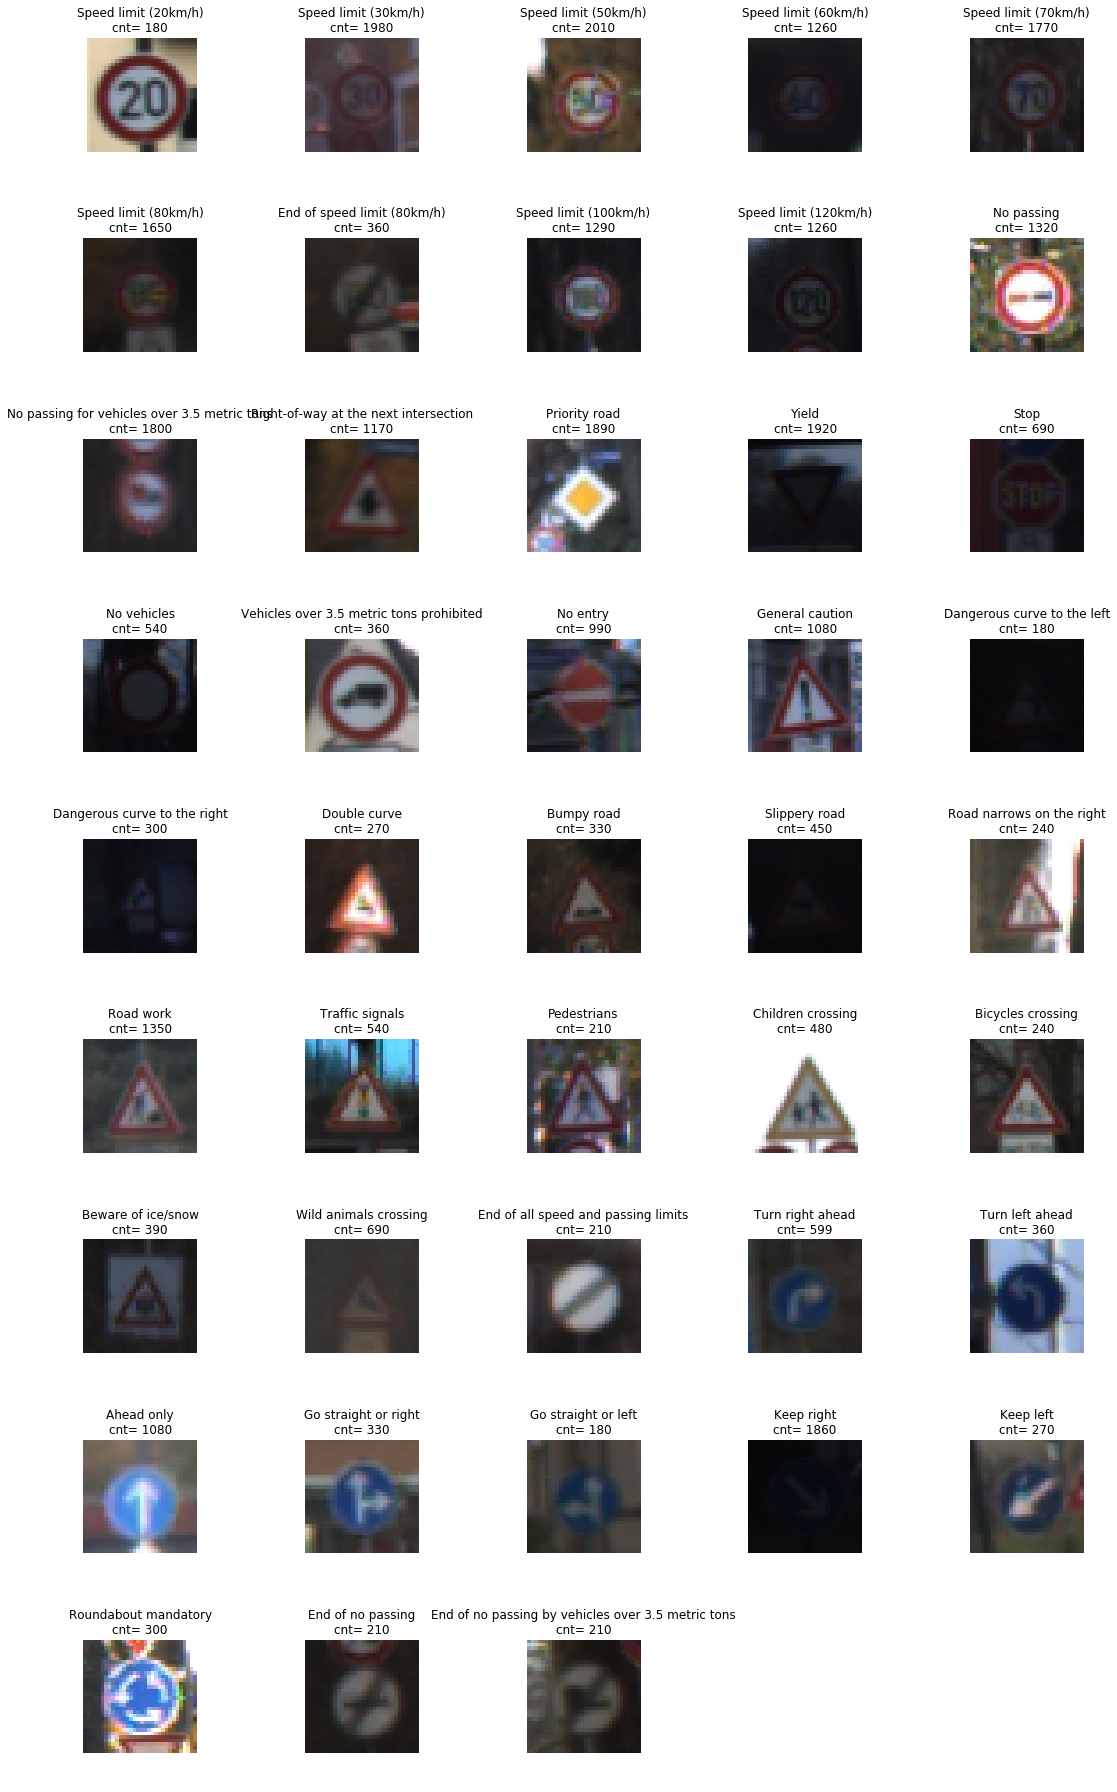

In [4]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
%matplotlib inline

import matplotlib.pyplot as plt
import cv2

n_row=5

f, ax = plt.subplots(int(n_classes/n_row)+1, n_row)

f.set_figheight(25)
f.set_figwidth(15)

#turn off axis
for a in ax:
    for b in a:
        b.axis('off') 

#for all signames draw an image
for val, name in signames.values:
    q=np.where(y_train==val)[0]
    now=ax[int(val/5)][val%5]
    
    now.set_title('%s\ncnt= %d' %(name,len(q)))
    now.imshow(X_train[q[0]])

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.axis('off') 
plt.savefig('images/Explore1.png')
plt.show()    

###  let's try to check number of each class in train/test/validate

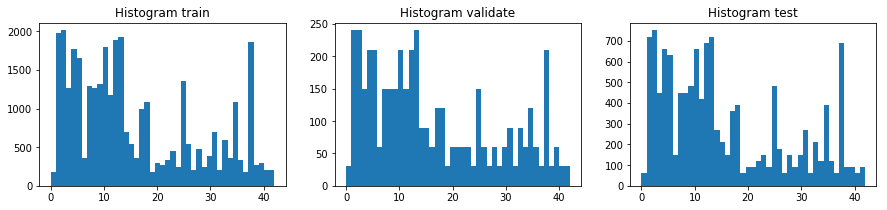

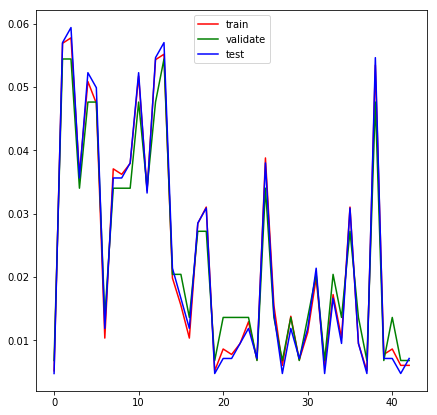

In [5]:
f, ax = plt.subplots(1,3)
f.set_figheight(3)
f.set_figwidth(15)

#better to do it with np.hist, but anyway...
from collections import Counter

total_hist=np.empty((3,n_classes))

cl=('train','validate','test')

for i, dist in enumerate((y_train,y_valid,y_test)):
    ax[i].set_title('Histogram %s' %cl[i])
    ax[i].hist(dist, bins=n_classes)
    
    c=Counter(dist)
    total_hist[i]=[c[j] for j in range(n_classes)]
    total_hist[i]/=total_hist[i].sum()
    
plt.savefig('images/hist1.png')
plt.show()
plt.figure(figsize=(7,7))

colors='rgb'

for i in range(3):
    plt.plot(range(n_classes),total_hist[i], c=colors[i], label=cl[i])
    plt.legend()
plt.savefig('images/hist2.png')
plt.show()

### so we have that distribution of target values are near similar, so we will assume that images are from the same dataset and we do not need to change number of examples per label

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [6]:
import cv2
normalizer = lambda x: (x-x.mean())/x.std()

def preprocess_v1(X):
    """
    Normalization and graysacalling
    """
    X=X.mean(axis=3).reshape((X.shape[0], X.shape[1], X.shape[2],1))
    
    #normalize
    return np.array(list(map(normalizer,X)))

In [7]:
import cv2
#normalizer = lambda x: (x-x.mean())/x.std()

def preprocess_v2(X, verbose=False, fname=None):
    """
    Normalization, convert to YUV and change mean of Y channel
    """
    if verbose:
        f, ax = plt.subplots(1, 5)
        f.set_figheight(5)
        f.set_figwidth(15)
        for a in ax:
            a.axis('off')
        ax[0].set_title('original')
        ax[0].imshow(X)
    
    #change color space
    X=cv2.normalize(X,np.zeros((32,32,3)),alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    if verbose:
        ax[1].set_title('Normalize')
        ax[1].imshow(X)
    
    
    
    X=cv2.cvtColor(X, cv2.COLOR_BGR2YUV).astype(np.float)
    
    for i in range(3):
        X[:,:,i]-=X[:,:,i].mean()
    
    
    if verbose:
        for i in range(3):
            
            ax[i+2].set_title('Channel %s' % 'YUV'[i])
            ax[i+2].imshow(X[:,:,i],cmap="gray")
        if fname:
            plt.savefig(fname)
        plt.show()
    return X

# example of images preprocessing_v2
1) normalize <br>
2) convert to YUV<br>
3) normalize for y channel<br>

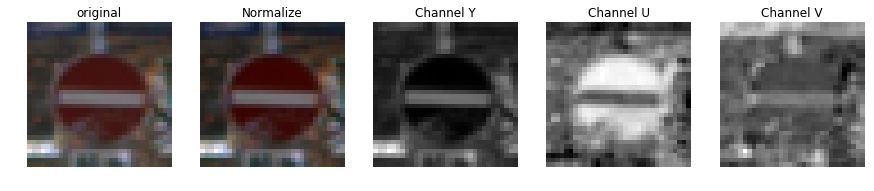

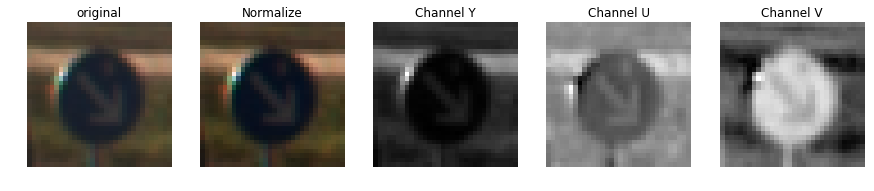

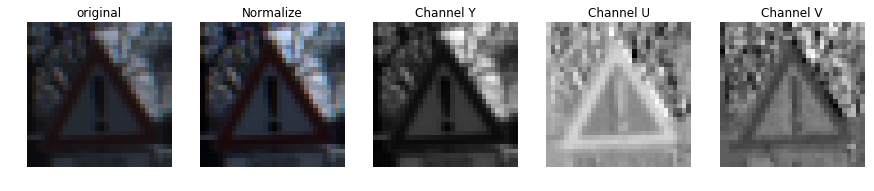

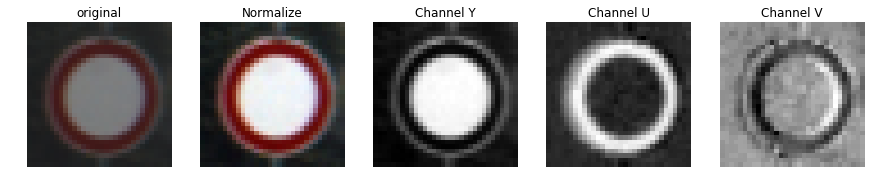

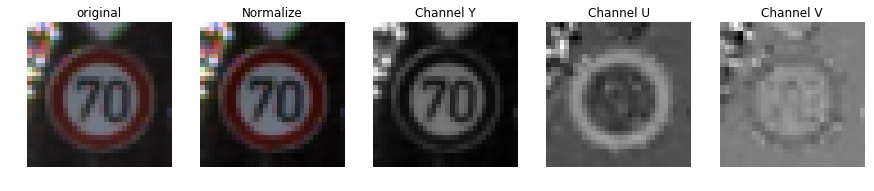

In [8]:
import numpy as np
#show in random examples
example=np.random.choice(len(X_train),5,replace=False)

for j,i in enumerate(example):
    tmp=preprocess_v2(X_train[i],verbose=True, fname='preprocess%d.png' % j)

In [9]:
#preprocessing using sklearn
from skimage.exposure import equalize_adapthist
def preprocess_v3(X, verbose=False, fname=None):
    """
    Preprocessing using skimage equalize_adapthist
    """
    tmp=equalize_adapthist(X,kernel_size=(6,6),clip_limit=0.2)
    if verbose:
        f, ax = plt.subplots(1, 2)
        f.set_figheight(5)
        f.set_figwidth(15)
        for a in ax:
            a.axis('off')
        ax[0].set_title('original')
        ax[0].imshow(X)
        
        ax[1].set_title('original')
        ax[1].imshow(tmp)
        
        if fname:
            plt.savefig(fname)
        plt.show()
    return tmp
            
        


/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


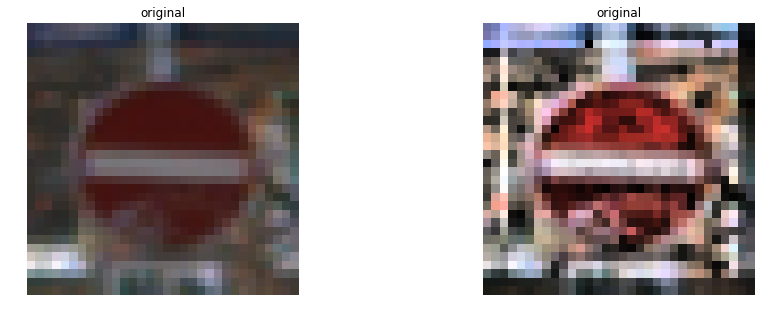

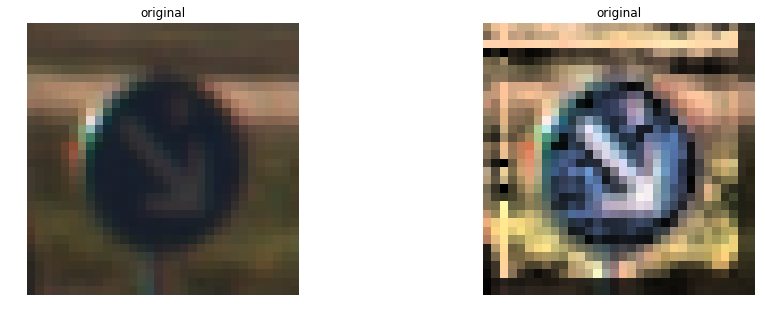

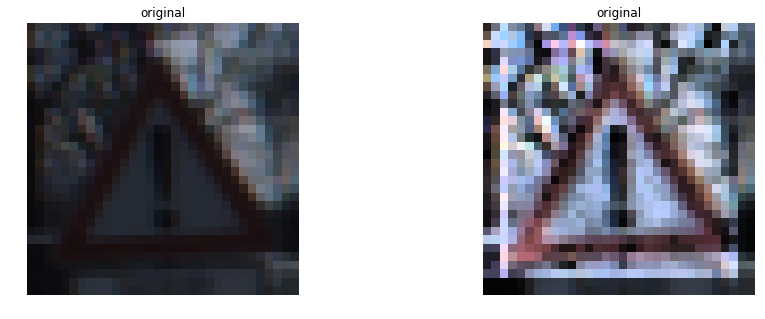

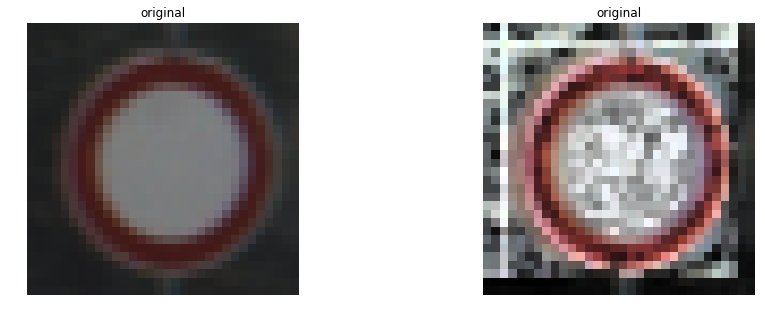

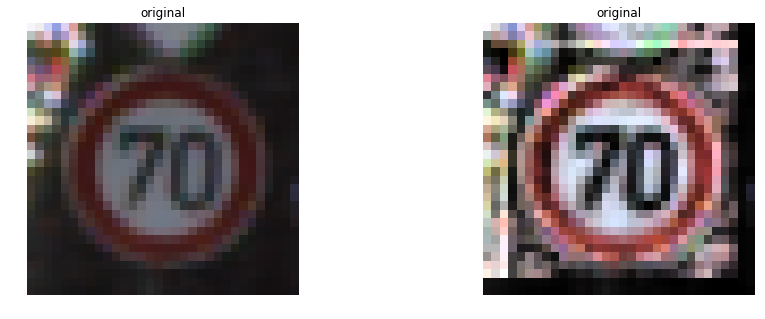

In [10]:
#show in random examples
for j,i in enumerate(example):
    tmp=preprocess_v3(X_train[i],verbose=True)

### Now we generate "Jittered dataset" like in paper - making random rotations and affine transformations

In [11]:
from itertools import product

def rotate(img, angle):
    """
    function to rotate 10 or -10
    """
    
    #no need to rotate
    if angle==0:
        return img
    
    rows,cols = img.shape[0],img.shape[1]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    tmp=np.zeros_like(img)
    for i in range(img.shape[2]):
        tmp[:,:,i]=cv2.warpAffine(img[:,:,i],M,(cols,rows))
    
    return tmp

def resize(img, side, where_cut):
    """
    Function for resize and crop image
    """
    tmp=None
    
    #if no need to resize
    if side==0:
        return img
    
    if side==1:
        tmp=cv2.resize(img,None,fx=1.2, fy=1, interpolation = cv2.INTER_CUBIC)[:32,:32]
    if side==-1:
        tmp=cv2.resize(img,None,fx=1, fy=1.2, interpolation = cv2.INTER_CUBIC)[:32,:32]
        
    if where_cut==1:
        return tmp[-32:,-32:]
    return tmp[:32,:32]

##todo rotate->resize and resize->rotate
def get_resized_and_rotated(img, cnt=-1):
    """
    get fixed number of resized and rotated images
    """
    all_variants=np.array([a for a in product([-10,0,10],[1,0,-1],[1,-1]) if not (a[0]==0 and a[1]==0)])
    #if needed only samples
    if cnt>0:
        all_variants=all_variants[np.random.choice(len(all_variants),cnt,replace=False)]
    
    return np.array([rotate(resize(img,a[1],a[2]),a[0]) for a in all_variants])

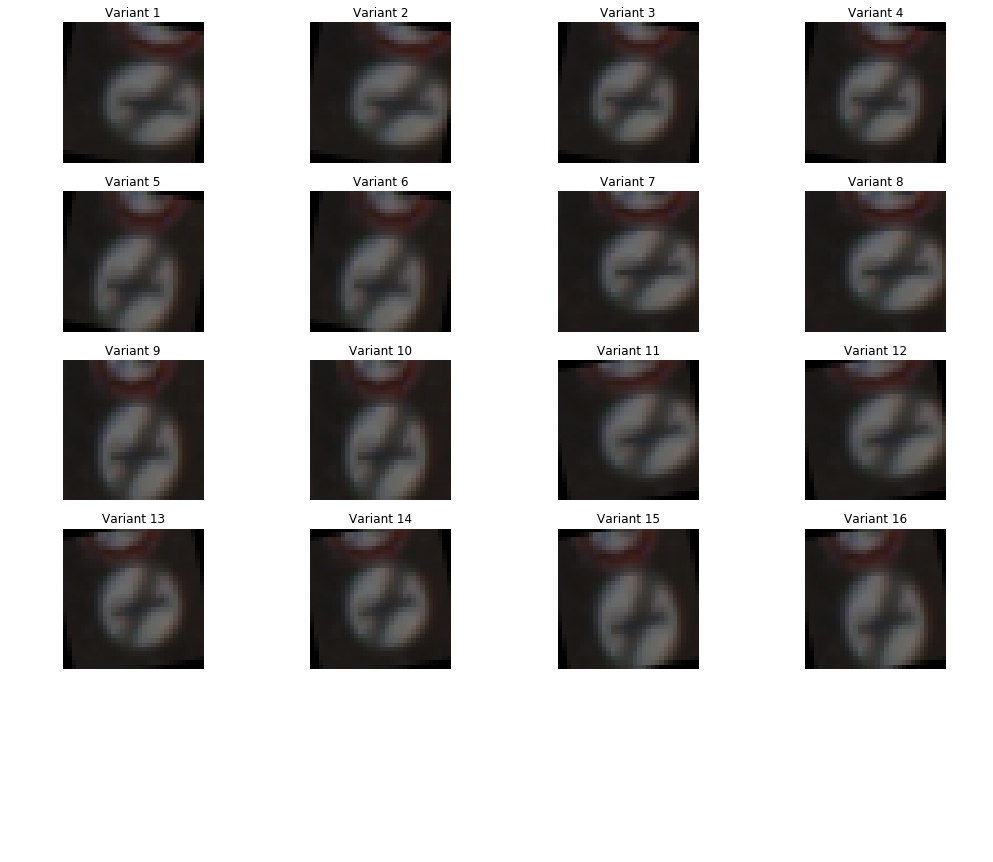

In [12]:
#example of random transformations
all_variants=get_resized_and_rotated(X_train[0], cnt=-1)

n_row=4

f, ax = plt.subplots(int(len(all_variants)/n_row)+1, n_row)

f.set_figheight(15)
f.set_figwidth(4*int(len(all_variants)/n_row)+1)

#turn off axis
for a in ax:
    for b in a:
        b.axis('off') 

#for all signames draw an image
for i,img in enumerate(all_variants):
    now=ax[int(i/n_row)][i%n_row]
    now.set_title('Variant %d' % (i+1))
    now.imshow(img)

plt.axis('off') 
plt.savefig('images/Jittered.png')
plt.show()    

In [13]:
def get_jittered_v1(X, y, cnt):
    """
    For each imge generate cnt of jittered images
    """
    X_jittered=np.concatenate([get_resized_and_rotated(a,4) for a in X])
    y_jittered=np.concatenate([[a for i in range(4)] for a in y])
    return np.concatenate([X,X_jittered]), np.concatenate([y,y_jittered])

In [14]:
def get_jittered_v2_sub (X,cnt):
    """
    Get fixed number of gittered images
    """
    ids=np.random.choice(len(X),cnt,replace=True)
    return np.concatenate([get_resized_and_rotated(X[i],1) for i in ids])


def get_jittered_v2 (X,y,cnt):
    """
    Get fixed number of images for each class
    """
    X_train_jittered2=np.empty((5000*n_classes,32,32,3), dtype=np.uint8)
    y_train_jittered2=np.empty(5000*n_classes,dtype=np.uint8)

    for i in range(n_classes):
        where=np.where(y==i)[0]
        cnt_have= len(where)
        X_train_jittered2[i*5000:(i*5000+cnt_have)]=X[where]
        X_train_jittered2[(i*5000+cnt_have):(i+1)*5000]=get_jittered_v2_sub(X[where],5000-cnt_have)
        y_train_jittered2[i*5000:(i+1)*5000]=i
        
    return X_train_jittered2,y_train_jittered2
    

In [15]:
from keras.preprocessing.image import ImageDataGenerator


def get_jittered_v3(X, y, cnt):
    """
    Same as v1, but using Keras
    """
    datagen = ImageDataGenerator(
        featurewise_center=False,
        featurewise_std_normalization=False,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=False)
    
    datagen.fit(X)
    
    new_X=np.empty((len(X)*(cnt+1),32,32,3),dtype=np.uint8)
    new_y=np.empty(len(X)*(cnt+1), dtype=np.uint8)
    print (new_X.shape, X.shape)
    i=0
    for tmp in datagen.flow(X,y,batch_size=len(X)):
        new_X[(i*len(X)):((i+1)*len(X))]=tmp[0]
        new_y[(i*len(X)):((i+1)*len(X))]=tmp[1]
        i+=1
        if i>cnt:
            break
    return (new_X,new_y)
    
def get_jittered_v4(X, y, cnt):
    """
    Same as v2, but using Keras
    """
    datagen = ImageDataGenerator(
        featurewise_center=False,
        featurewise_std_normalization=False,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=False)
    
    X_train_jittered2=np.empty((cnt*n_classes,32,32,3), dtype=np.uint8)
    y_train_jittered2=np.empty(cnt*n_classes,dtype=np.uint8)


    for i in range(n_classes):
        w=np.where(y==i)[0]
        datagen.fit(X[w])
        #print (cnt, len(w))
        now=i*cnt
        y_train_jittered2[now:(now+cnt)]=i
        for tmp in datagen.flow(X[w],y[w],batch_size=cnt):
            j=min([now+len(tmp[0]),(i+1)*cnt])
            size=(i+1)*cnt-j
            #print (i,j,size,tmp[0].shape)
            X_train_jittered2[now:j]=tmp[0][:size]
            now+=cnt
            if now>(i+1)*cnt:
                break
    return X_train_jittered2, y_train_jittered2

Using TensorFlow backend.


###  now we have:

1) 3 kind of different preprocessing techincs

2) 4 kind of jittered datasets

3) two easy changeble parametrs in our model - dropout for convolution and normal layers, let's try 1 and 0.5 only

so we have to try 3 x 4 x 4=48 different models

In [17]:
import os
import pickle
if not os.path.exists('all.p'):
    Xs=[None for i in range(4)]
    ys=[None for i in range(4)]

    Xs[0],ys[0] = get_jittered_v1(X_train,y_train,4)
    Xs[1],ys[1] = get_jittered_v2(X_train,y_train,5000)
    Xs[2],ys[2] = get_jittered_v3(X_train,y_train,4)
    Xs[3],ys[3] = get_jittered_v4(X_train,y_train,5000)
    
    f=open('all.p','wb')
    pickle.dump([Xs, ys],f, -1)
    f.close()
else:
    f=open('all.p','rb')
    Xs, ys=pickle.load(f)
    f.close()

%%time
#preprocessing
import os
if not os.path.exists('all_v2.p'):

    #X_train=np.array([preprocess_v2(a) for a in np.concatenate([X_train,X_train_jittered])])
    X_train=X_train_jittered2= np.array([preprocess_v2(a) for a in X_train_jittered2])
    X_valid=np.array([preprocess_v2(a) for a in X_valid])
    X_test=np.array([preprocess_v2(a) for a in X_test])

    #y_train=np.concatenate([y_train,y_train_jittered])
    y_train=y_train_jittered2
    
    f=open('all_v2.p','wb')
    pickle.dump([X_train,X_valid,X_test,y_train],f, -1)
    f.close()
else:
    f=open('all_v2.p','rb')
    X_train,  X_valid, X_test, y_train = pickle.load(f)
    f.close()

### Model Architecture

In [18]:
#added droput layer to prevent overfitting

from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1_pool, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2_pool)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
    #added - dropout, to prevent overfitting
    fc1_drop = tf.nn.dropout(fc1, keep_prob)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1_drop, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return (conv1, conv2,  logits)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [19]:
import tensorflow as tf

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

In [20]:
rate = 0.001

conv1, conv2, logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [21]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [22]:
from tqdm import tqdm_notebook, tqdm
from copy import deepcopy

X_valid_copy=deepcopy(X_valid)
y_valid_copy=deepcopy(y_valid)

In [23]:
from itertools import product

variants=[a for a in product(range(4),range(2),[1,0.5])]
print (variants,len(variants))
np.save('variants',variants)

[(0, 0, 1), (0, 0, 0.5), (0, 1, 1), (0, 1, 0.5), (1, 0, 1), (1, 0, 0.5), (1, 1, 1), (1, 1, 0.5), (2, 0, 1), (2, 0, 0.5), (2, 1, 1), (2, 1, 0.5), (3, 0, 1), (3, 0, 0.5), (3, 1, 1), (3, 1, 0.5)] 16


In [ ]:
EPOCHS = 100
BATCH_SIZE = 128
from sklearn.utils import shuffle
import datetime
valid_acc=np.zeros(EPOCHS, dtype=np.float)
train_acc=np.zeros(EPOCHS, dtype=np.float)

from multiprocessing import Pool
from contextlib import closing



for iteration, (n_X, type_of_process, keep_prob_current) in enumerate(variants):
    if os.path.exists('results/res_%d.p' % iteration):
        print ('Skipping iteration %d' % iteration)
        continue
    
    with closing(Pool(12)) as mpool:
        #preprocessing
        if type_of_process==0:
            #np.array(mpool.map(preprocess_v3, Xs[0]))
            X_train, X_valid = np.array(mpool.map(preprocess_v2, Xs[n_X].astype(np.uint8))), \
                np.array(mpool.map(preprocess_v2, X_valid_copy))
        else:
            X_train, X_valid = np.array(mpool.map(preprocess_v3, Xs[n_X].astype(np.uint8))), \
                np.array(mpool.map(preprocess_v3, X_valid_copy))

        y_train, y_valid = deepcopy(ys[n_X]), deepcopy(y_valid_copy)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)

        #print("Training...")
        #print()
        for i in tqdm(range(EPOCHS)):
            X_train, y_train = shuffle(X_train, y_train)
            for offset in (range(0, num_examples, BATCH_SIZE)):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:keep_prob_current})

            validation_accuracy = evaluate(X_valid, y_valid)
            training_accuracy=    evaluate(X_train, y_train)

            valid_acc[i]=validation_accuracy
            train_acc[i]=training_accuracy

            #print("EPOCH {} ...".format(i+1), datetime.datetime.now())
            #print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            #print("Training   Accuracy = {:.3f}".format(training_accuracy))
            #print()

        saver.save(sess, './nets/lenet_%d' % iteration)
        
        f=open('results/res_%d.p' % iteration,'wb')
        pickle.dump([train_acc, valid_acc, n_X, type_of_process, keep_prob_current],f, -1)
        f.close()
        
        print("Model saved, best score for %d %d %f was %f" % \
              (n_X, type_of_process, keep_prob_current,max(valid_acc)))

Skipping iteration 0
Skipping iteration 1
Skipping iteration 2
Skipping iteration 3
Skipping iteration 4
Skipping iteration 5
Skipping iteration 6
Skipping iteration 7
Skipping iteration 8
Skipping iteration 9
Skipping iteration 10
Skipping iteration 11


100%|██████████| 100/100 [21:47<00:00, 12.97s/it]

Model saved, best score for 3 0 1.000000 was 0.854875
Skipping iteration 13
Skipping iteration 14
Skipping iteration 15


In [63]:
res_valid=np.empty((16,100),dtype=np.float)
res_train=np.empty((16,100),dtype=np.float)

In [64]:
params=[]

for iteration, (n_X, type_of_process, keep_prob_current) in enumerate(variants):
    f=open('results/res_%d.p'%iteration,'rb')
    data=pickle.load(f)
    f.close()
    
    res_valid[iteration]=data[1]
    res_train[iteration]=data[0]
    params.append([n_X, type_of_process, keep_prob_current])

In [65]:
df_results=pd.DataFrame(params, columns=['n_x','type_of_process','keep_prob'])
df_results['valid']=res_valid.max(axis=1)
df_results['train']=res_train.max(axis=1)

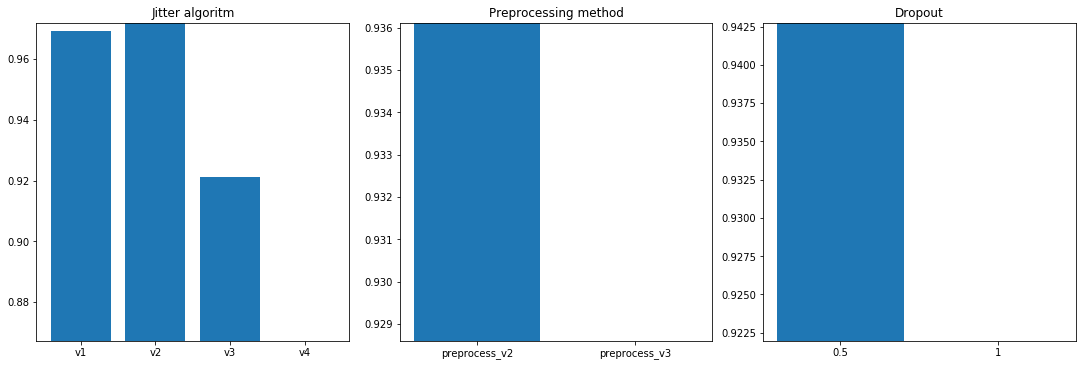

In [66]:
#df_results.sort_values('valid',ascending=False)
#df_results.groupby('n_x')['valid'].mean().reset_index()

f, ax = plt.subplots(1, 3)

f.set_figheight(5)
f.set_figwidth(15)



xnames=[['v1','v2','v3','v4'],['preprocess_v2','preprocess_v3'],['0.5','1']]
names=['Jitter algoritm','Preprocessing method','Dropout']

for i,metric in enumerate(('n_x','type_of_process','keep_prob')):
    tmp=df_results.groupby(metric)['valid'].mean().reset_index().sort_values(metric).values
    #print (tmp)
    ax[i].set_title(names[i])
    ax[i].bar(range(len(tmp)),tmp[:,1])
    ax[i].set_ylim((tmp[:,1].min(),tmp[:,1].max()))
    plt.sca(ax[i])
    plt.xticks(range(len(tmp)),xnames[i])
    plt.yticks

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig('images/avg_score.png')
plt.show()
    

### in averge second and first generaging technic (using my functions) 
### preprocessing using YUV-colorspace was better, than skimage,
### and adding dropout gives good result :)

### but of course all of it in average - individual best score could be somewhere in middle
### and training validation is too small, unfortunately

In [67]:
df_results['X_name']=df_results['n_x'].apply(lambda x:xnames[0][x])
df_results['process_and_droout']=df_results[['type_of_process','keep_prob']].\
apply(lambda x:', '.join([xnames[i+1][int(a)] for i,a in enumerate(x)]),axis=1)

In [72]:
df_res_pivot=df_results.pivot('X_name','process_and_droout','valid').reset_index()

heatmap=df_res_pivot[['preprocess_v2, 0.5', 'preprocess_v2, 1',\
       'preprocess_v3, 0.5', 'preprocess_v3, 1']].values

df_res_pivot

process_and_droout X_name  preprocess_v2, 0.5  preprocess_v2, 1  \
0                      v1            0.983673          0.963719   
1                      v2            0.976190          0.970522   
2                      v3            0.935828          0.904082   
3                      v4            0.900000          0.854875   

process_and_droout  preprocess_v3, 0.5  preprocess_v3, 1  
0                             0.967800          0.961224  
1                             0.974150          0.966667  
2                             0.937868          0.907029  
3                             0.866440          0.847619

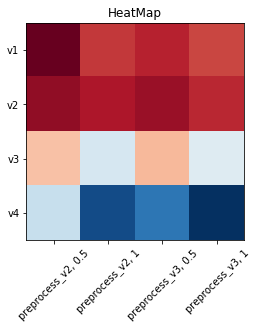

In [69]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('HeatMap')
plt.imshow(heatmap, cmap=plt.cm.RdBu_r, interpolation='nearest')
plt.xticks(range(4),['preprocess_v2, 0.5', 'preprocess_v2, 1',\
       'preprocess_v3, 0.5', 'preprocess_v3, 1'],rotation=45)
plt.yticks(range(4),df_res_pivot['X_name'].values)

plt.savefig('images/heatmap.png')

plt.show()

### So, the best accurancy is for preprocess_v2, dropout= 0.5 and jittering methods v_1 and v_2, but in average the best jittering method 2 was better then first one

### Let's plot their performances

In [75]:
df_results

n_x  type_of_process  keep_prob     valid     train X_name  \
0     0                0        1.0  0.963719  0.999621     v1   
1     0                0        0.5  0.983673  0.999483     v1   
2     0                1        1.0  0.961224  0.999109     v1   
3     0                1        0.5  0.967800  0.996638     v1   
4     1                0        1.0  0.970522  0.999716     v2   
5     1                0        0.5  0.976190  0.999428     v2   
6     1                1        1.0  0.966667  0.999298     v2   
7     1                1        0.5  0.974150  0.998470     v2   
8     2                0        1.0  0.904082  0.992149     v3   
9     2                0        0.5  0.935828  0.970332     v3   
10    2                1        1.0  0.907029  0.990402     v3   
11    2                1        0.5  0.937868  0.956413     v3   
12    3                0        1.0  0.854875  0.182944     v4   
13    3                0        0.5  0.900000  0.179437     v4   
14    3                1        1.0  0.847619  0.182898     v4   
15    3                1        0.5  0.866440  0.174102     v4   

    process_and_droout  
0     preprocess_v2, 1  
1   preprocess_v2, 0.5  
2     preprocess_v3, 1  
3   preprocess_v3, 0.5  
4     preprocess_v2, 1  
5   preprocess_v2, 0.5  
6     preprocess_v3, 1  
7   preprocess_v3, 0.5  
8     preprocess_v2, 1  
9   preprocess_v2, 0.5  
10    preprocess_v3, 1  
11  preprocess_v3, 0.5  
12    preprocess_v2, 1  
13  preprocess_v2, 0.5  
14    preprocess_v3, 1  
15  preprocess_v3, 0.5

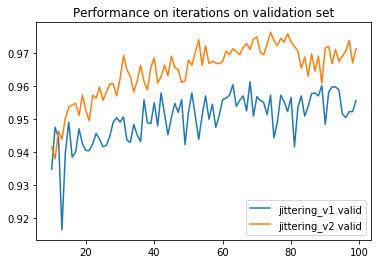

Best iteration for best is  85 with value 0.967800453515
Best iteration for question is  97 with value 0.937868480077


In [76]:
plt.title('Performance on iterations on validation set')
for i,name in zip((2, 5),('jittering_v1','jittering_v2')):
    plt.plot(range(10,100),res_valid[i][10:], label=name+' valid')
    #plt.plot(res_train[i][10:], label=name+' train')
    
plt.legend()
plt.show()

print ('Best iteration for best is ',np.argmax(res_valid[3]), 'with value', res_valid[3].max())
print ('Best iteration for question is ',np.argmax(res_valid[11]),'with value', res_valid[11].max())

### so, as we see that on validation set performance was increasing. Let's try more iterations for best algoritm.

In [24]:
%%sh

mkdir logs

In [ ]:
EPOCHS = 200
BATCH_SIZE = 128
from sklearn.utils import shuffle
import datetime
valid_acc=np.zeros(EPOCHS, dtype=np.float)
train_acc=np.zeros(EPOCHS, dtype=np.float)

import os

n_X=0
type_of_process=0
keep_prob_current=0.5

    
#preprocessing
if type_of_process==0:
    X_train, X_valid = np.array([preprocess_v2(a) for a in Xs[n_X]]), \
        np.array([preprocess_v2(a) for a in X_valid_copy])
else:
    X_train, X_valid = np.array([preprocess_v3(a) for a in Xs[n_X]]), \
        np.array([preprocess_v3(a) for a in X_valid_copy])

y_train, y_valid = deepcopy(ys[n_X]), deepcopy(y_valid_copy)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    summary_writer = tf.summary.FileWriter('/logs', graph=tf.get_default_graph())

    for i in tqdm(range(EPOCHS)):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in (range(0, num_examples, BATCH_SIZE)):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})

        validation_accuracy = evaluate(X_valid, y_valid)
        training_accuracy=    evaluate(X_train, y_train)

        valid_acc[i]=validation_accuracy
        train_acc[i]=training_accuracy


    saver.save(sess, './lenet')


    print("Model saved")
    np.save('valid_acc_1.np',valid_acc)
    np.save('train_acc_1.np',train_acc)
    

  1%|          | 2/200 [04:00<6:35:19, 119.80s/it]

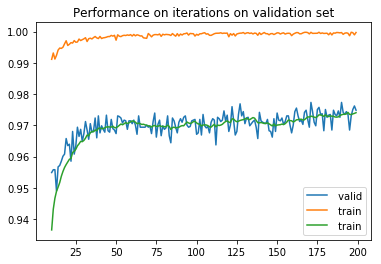

Best iteration for valid is  171
Best score is  0.977324263039
Best iteration for moving avearge is  196
Best score is  0.975359032331


In [88]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.title('Performance on iterations on validation set')
plt.plot(range(10,200),valid_acc[10:], label=' valid')
plt.plot(range(10,200),train_acc[10:], label=' train')
plt.plot(range(10,200),moving_average(valid_acc[1:],10), label=' train')


    #plt.plot(res_train[i][10:], label=name+' train')
    
plt.legend()
plt.savefig('images/accurancy_on_valid.png')
plt.show()

print ('Best iteration for valid is ',np.argmax(valid_acc))
print ('Best score is ', valid_acc.max())

print ('Best iteration for moving avearge is ',\
       np.argmax(moving_average(valid_acc[1:])))
print ('Best score is ', moving_average(valid_acc[1:]).max())

### in this case model looks underfitted. but in previous test with the same parametrs we had 0.983 on 50 iterations - so there a a big part of random, we need more data and make cross validation to make a decision

In [90]:
with closing(Pool(12)) as mpool:
    X_test_v3=np.array(mpool.map(preprocess_v2, X_test))

In [91]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_v3, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.953


In [93]:
from sklearn.metrics import accuracy_score
pred_test = np.empty((n_test,n_classes), dtype=np.float)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    for offset in range(0, n_test, BATCH_SIZE):
        batch_x = X_test_v3[offset:offset+BATCH_SIZE]
        preds = sess.run(tf.nn.softmax(logits), feed_dict={x: batch_x, keep_prob:1})
        pred_test[offset:offset+BATCH_SIZE]=preds 
        
#validate that our score is ok
accuracy_score(y_test,np.argmax(pred_test,axis=1))

0.95265241488519403

In [94]:
tmp=np.zeros((n_classes,3), dtype=np.float)

for i in range(n_classes):
    w=np.where(y_test==i)[0]
    tmp[i] =(len(w), float(len(np.where(y_train==i)[0]))/len(y_train), accuracy_score(y_test[w],np.argmax(pred_test,axis=1)[w]))
    
df_preds=pd.DataFrame(tmp,columns=['cnt_test','cnt_train','accurancy_test'])

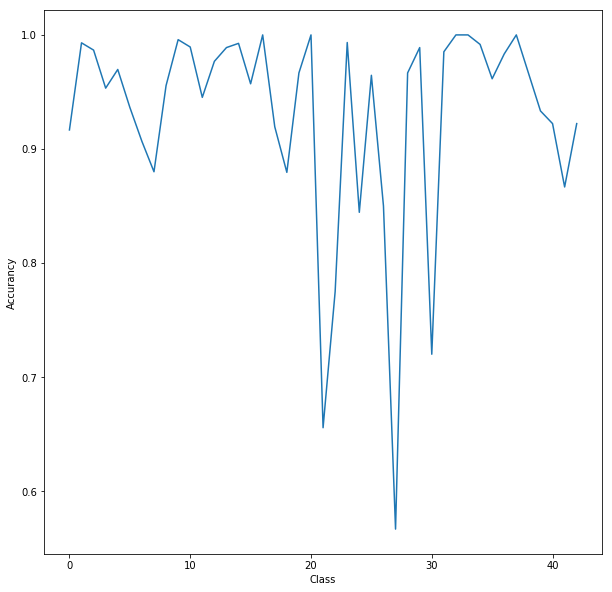

In [95]:
plt.figure(figsize=(10,10))
plt.plot(df_preds['accurancy_test'].values)
plt.xlabel('Class')
plt.ylabel('Accurancy')
#plt.xticks(range(n_classes),signames.SignName.values,rotation=45)
plt.show()

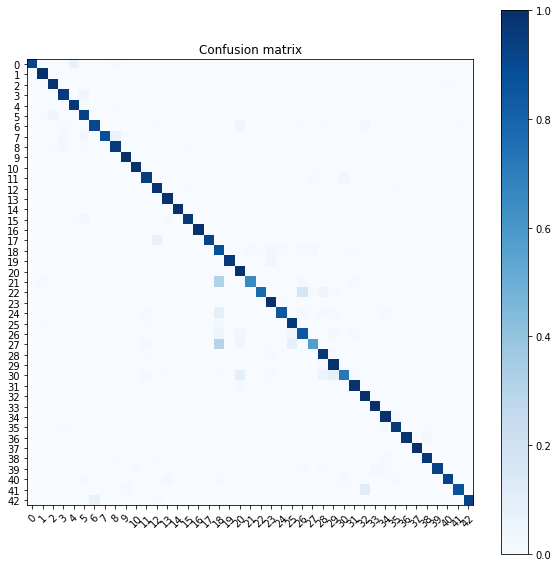

In [130]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    #for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
    #    plt.text(j, i, cm[i, j],
    #             horizontalalignment="center",
    #             color="white" if cm[i, j] > thresh else "black")
        

cnf_matrix = confusion_matrix(y_test, np.argmax(pred_test,axis=1))

cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, range(n_classes), rotation=45)
plt.yticks(tick_marks, range(n_classes))
plt.savefig('confusion_matrix.png')

plt.show()


In [100]:
with closing(Pool(12)) as mpool:
    X_test_v4=np.array(mpool.map(preprocess_v3, X_test))

/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision lo

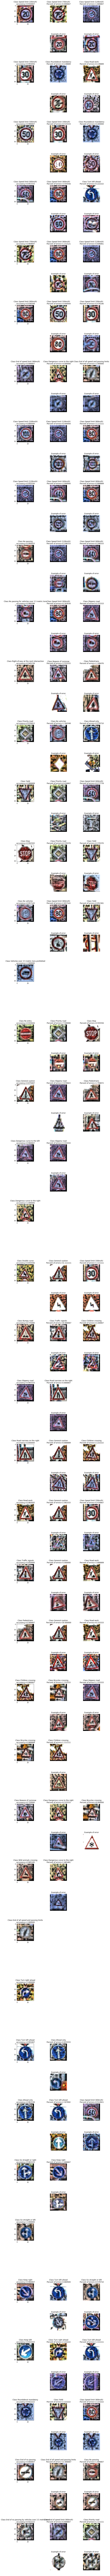

In [101]:
from collections import Counter
f, ax = plt.subplots(n_classes*2,3)

f.set_figheight(250)
f.set_figwidth(10)

for i in range(n_classes):
    w=np.where(y_test==i)[0]
    preds_current=np.argmax(pred_test,axis=1)[w]
    acc=accuracy_score(y_test[w],preds_current)
    
    ax[2*i][0].imshow(X_test_v4[w][0])
    ax[2*i][0].set_title('Class %s\n accurancy=%4f' % (signames.values[i][1],acc))
    ax[2*i+1][0].axis('off') 
    
    other=Counter([a for a in preds_current if a!=i]).most_common(4)
    
    for j in range(2):
        ax[2*i][j+1].axis('off') 
        ax[2*i+1][j+1].axis('off') 
        if j<len(other):
            er_class, cnt_errors = other[j]
            ax[2*i][j+1].imshow(X_test_v4[np.where(y_test==er_class)[0][0]])
            ax[2*i][j+1].set_title('Class %s\n Percent of errors=%2f' % \
                                 (signames.values[er_class][1],100*float(cnt_errors)/len(w)))
            
            
            ax[2*i+1][j+1].imshow(X_test_v4[w][np.where(preds_current==er_class)][0])
            ax[2*i+1][j+1].set_title('Example of error')
            
                       
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.axis('off') 
plt.savefig('images/Example_of_erros.png')

plt.show()

### we can calculate correlation between % of class in train data set and accuancy  - and we see that it's high, so we need more examples. 

In [103]:
from scipy.stats import pearsonr

pearsonr(df_preds.cnt_train.values,df_preds.accurancy_test.values)[0]

0.31166091316705907

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [36]:
from wget import download
from PIL import Image
import os

real=False

if real:
    os.system('rm *.jpg')

image_urls=['https://upload.wikimedia.org/wikipedia/commons/f/f9/STOP_sign.jpg',\
            'http://media.gettyimages.com/photos/german-traffic-signs-picture-id459381091?s=170667a',\
            'http://media.gettyimages.com/photos/speed-limit-on-country-road-picture-id503368326?s=170667a',\
            'http://media.gettyimages.com/photos/german-traffic-signs-picture-id459381017?s=170667a',\
            'http://media.gettyimages.com/photos/german-priority-sign-picture-id157296103?s=170667a'
           ]
if real:
    for i,a in enumerate(image_urls):
        download(a,out='%d.jpg'%i)

In [37]:
crops=[(0,0,1389,1389),(0,0,359,359),(100,0,100+338,338),(0,0,359,359),(0,30,341,30+341)]

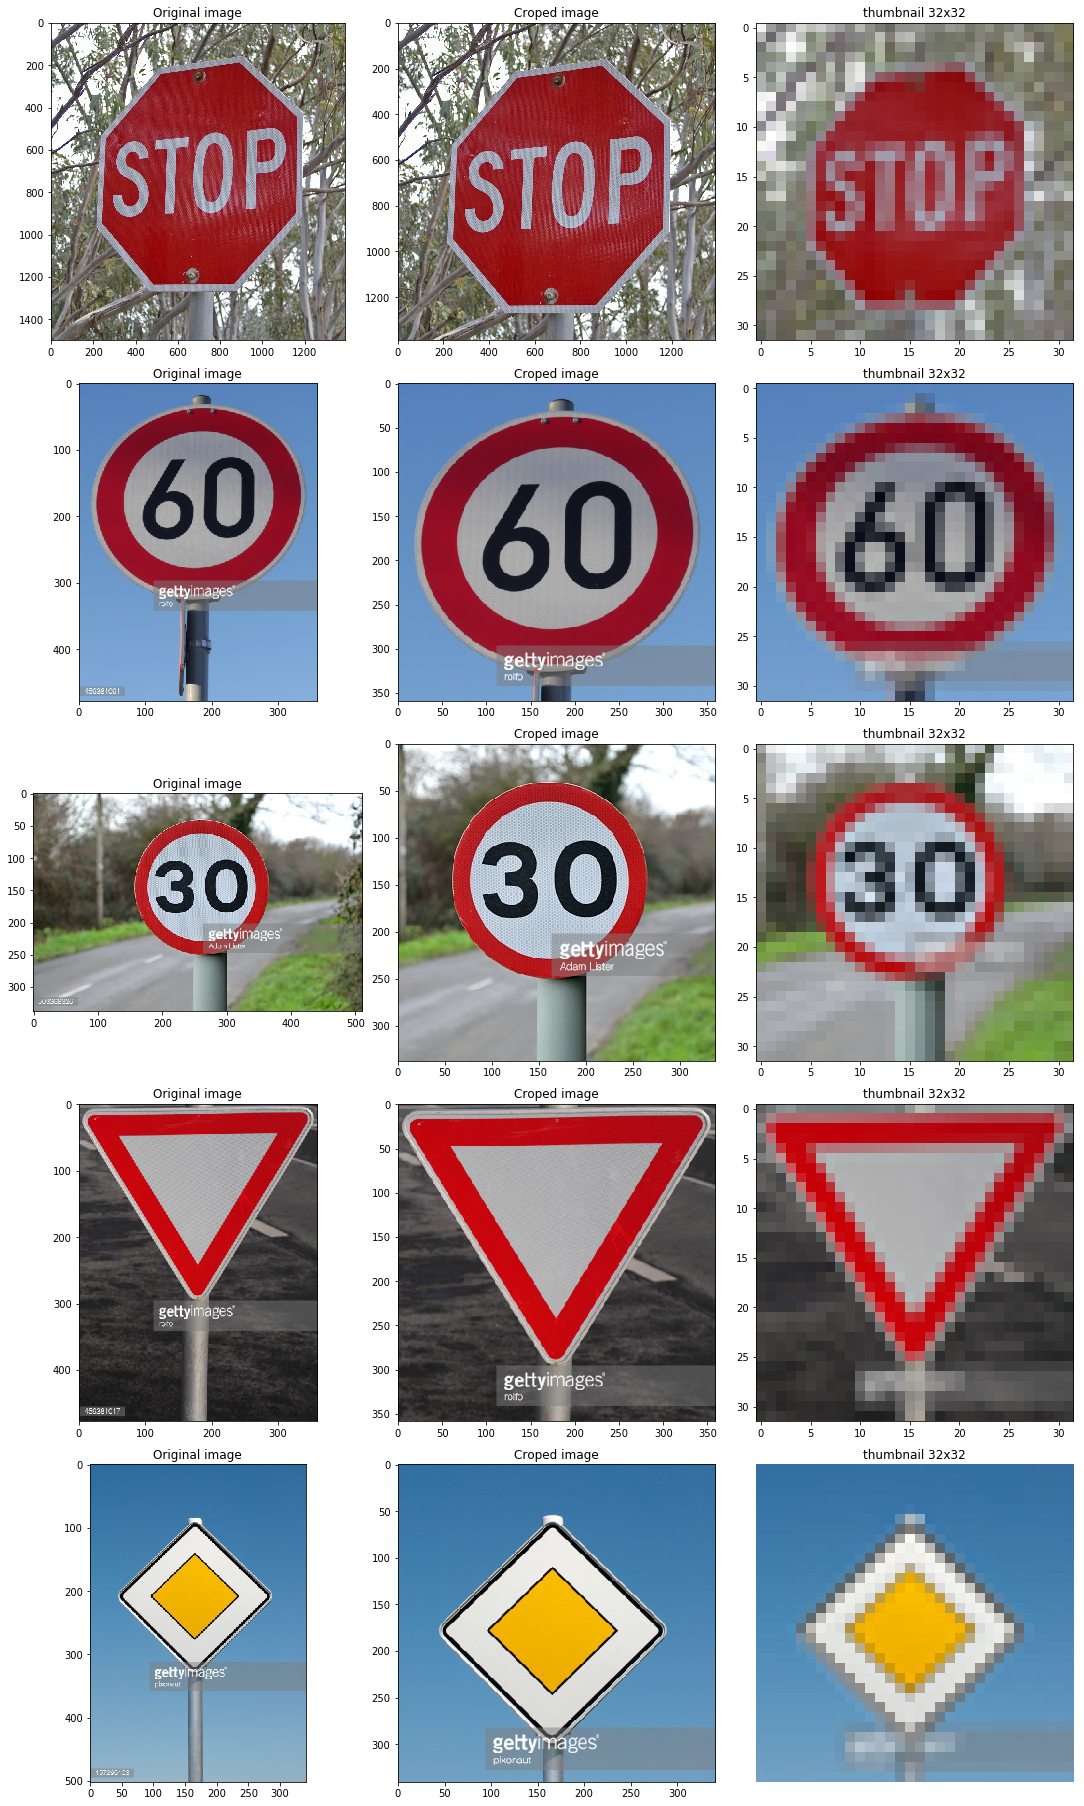

In [38]:
for_test=np.empty((len(image_urls),32,32,3), dtype=np.uint8)

f, ax = plt.subplots(5, 3)
f.set_figheight(25)
f.set_figwidth(15)


for i in range(len(image_urls)):
    image=Image.open('%d.jpg' %i)
    #print (image.size)
    ax[i][0].imshow(image)
    ax[i][0].set_title('Original image')
    
    
    image=image.crop(crops[i])
    ax[i][1].imshow(image)
    ax[i][1].set_title('Croped image')
    
    image.thumbnail((32,32))
    ax[i][2].imshow(image)
    ax[i][2].set_title('thumbnail 32x32')
    
    for_test[i]=image
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.axis('off') 
plt.savefig('images/new_images.png')


plt.show()

### Predict the Sign Type for Each Image

In [39]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

preprocessed=np.array([preprocess_v2(a) for a in for_test])

In [40]:
#get top-5 predictions
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top_k = sess.run(tf.nn.top_k(tf.nn.softmax(logits),k=5), feed_dict={x: preprocessed,keep_prob:1})
    

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


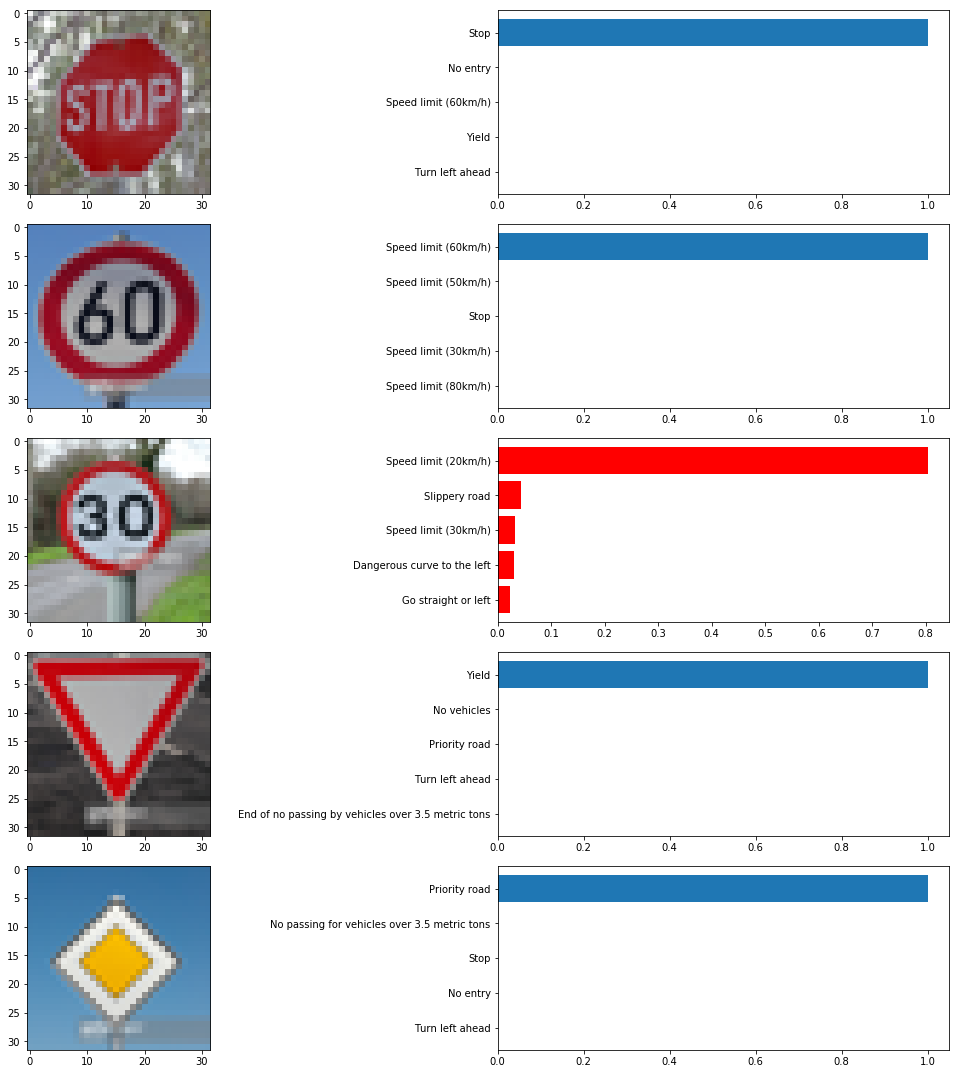

In [41]:
f, ax = plt.subplots(5, 2)
f.set_figheight(15)
f.set_figwidth(15)
      
    
for i in range(5):
    
    inds=top_k.indices[i]
    text=''
    for ind,prob in zip (top_k.indices[i], top_k.values[i]):
        text+='%s %.2f \n' % (signames.values[ind][1], prob*100)
    
    
    #plt.text(35, 0.95, text,  fontsize=14,
    #    verticalalignment='top')
    ax[i][0].imshow(for_test[i])
    
    if i==2:
        ax[i][1].barh(5-np.array(range(5)), top_k.values[i], color='red')
    else:
        ax[i][1].barh(5-np.array(range(5)), top_k.values[i])

    plt.sca(ax[i][1])
    plt.yticks(5-np.array(range(5)), [signames.values[j][1] for j in top_k.indices[i]])
    
f.tight_layout(pad=1, w_pad=1, h_pad=1.0)
f.savefig('images/model_preformance.png')
f.show()

    

### Analyze Performance

# Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

# 4/5 predicted correctly -> accurancy in 80% - compared to 0.95 on test dataset

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [122]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

---

## Step 4: Visualize the Neural Network's State with Test Images



In [42]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

from math import ceil

def outputFeatureMap(real_image, image_input, tf_activation, activation_min=-1, \
                     activation_max=-1 ,plt_num=1, name=None, n_col=8, height=15):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation_all = tf_activation.eval(session=sess,feed_dict={x : image_input,keep_prob:1})
    
    n_row=activation_all.shape[0] *ceil((1+activation_all.shape[3])/n_col)
    f, ax = plt.subplots( n_row, n_col)
    f.set_figheight(height)
    f.set_figwidth(15)
    
    for i,j in product(range(n_row),range(n_col)):
        ax[i][j].axis('off') 
   
    current_row=0
    current_column=0
    
    for i in range(len(activation_all)):
        if current_column!=0:
            current_column=1
            current_row+=1
            
        ax[current_row,0].imshow(real_image[i])
        if current_column==0:
            current_column+=1
        activation=activation_all[i:(i+2),:,:,:]
        featuremaps = activation.shape[3]
        for featuremap in range(featuremaps):
            #plt.subplot(6,8, featuremap+2) # sets the number of feature maps to show on each row and column
            ax[current_row,current_column].set_title('FeatureMap ' + str(featuremap)) # displays the feature map number
            tmp=activation[0,:,:, featuremap]
            #print (current_row,current_column)
            
            if activation_min != -1 & activation_max != -1:
                ax[current_row,current_column].imshow(tmp, interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
            elif activation_max != -1:
                ax[current_row,current_column].imshow(tmp, interpolation="nearest", vmax=activation_max, cmap="gray")
            elif activation_min !=-1:
                ax[current_row,current_column].imshow(tmp, interpolation="nearest", vmin=activation_min, cmap="gray")
            else:
                ax[current_row,current_column].imshow(tmp, interpolation="nearest", cmap="gray")
            current_column+=1
            if current_column==n_col:
                current_column=0
                current_row+=1
            
        
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    if name:
            plt.savefig(name)
    plt.show()

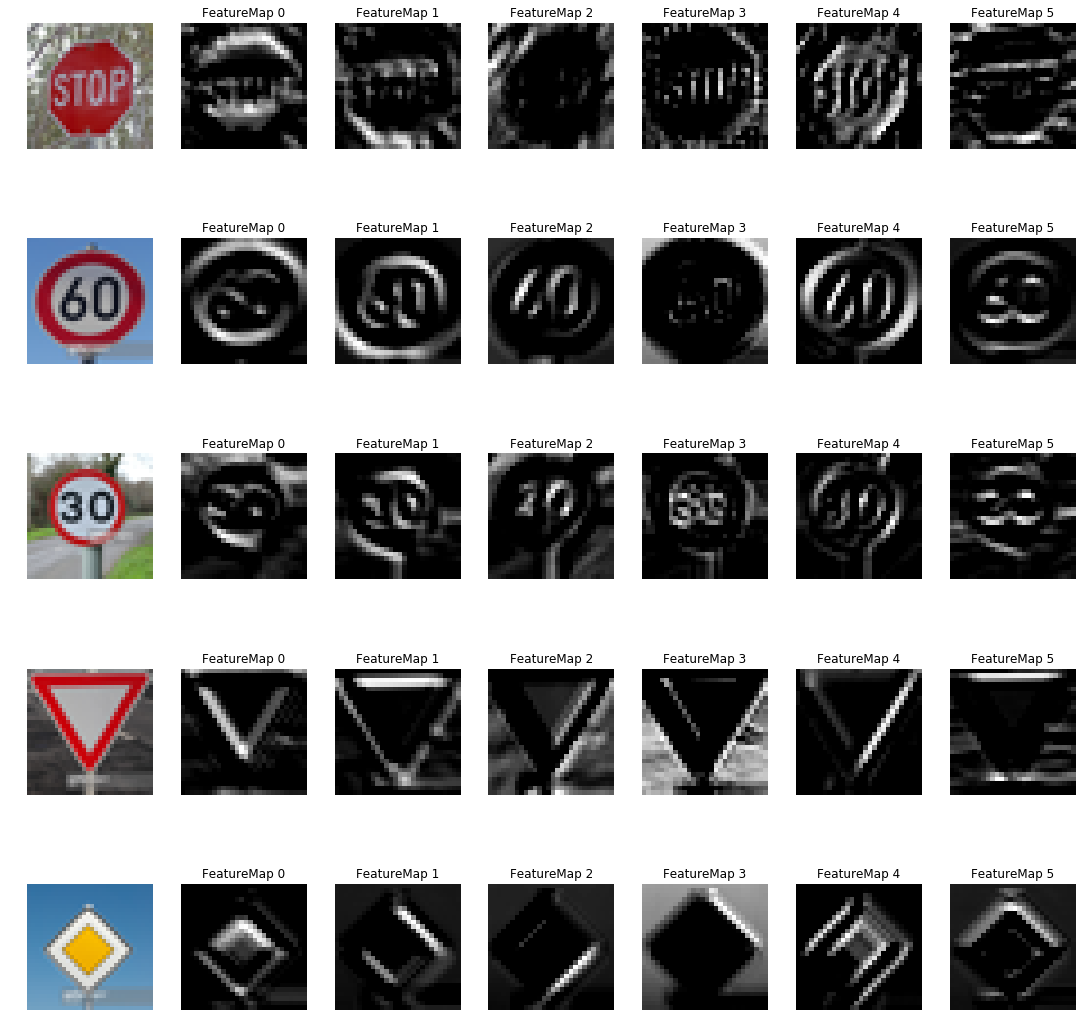

In [43]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    outputFeatureMap(for_test, preprocessed,conv1,name= 'images/convolution1.png',n_col=7)

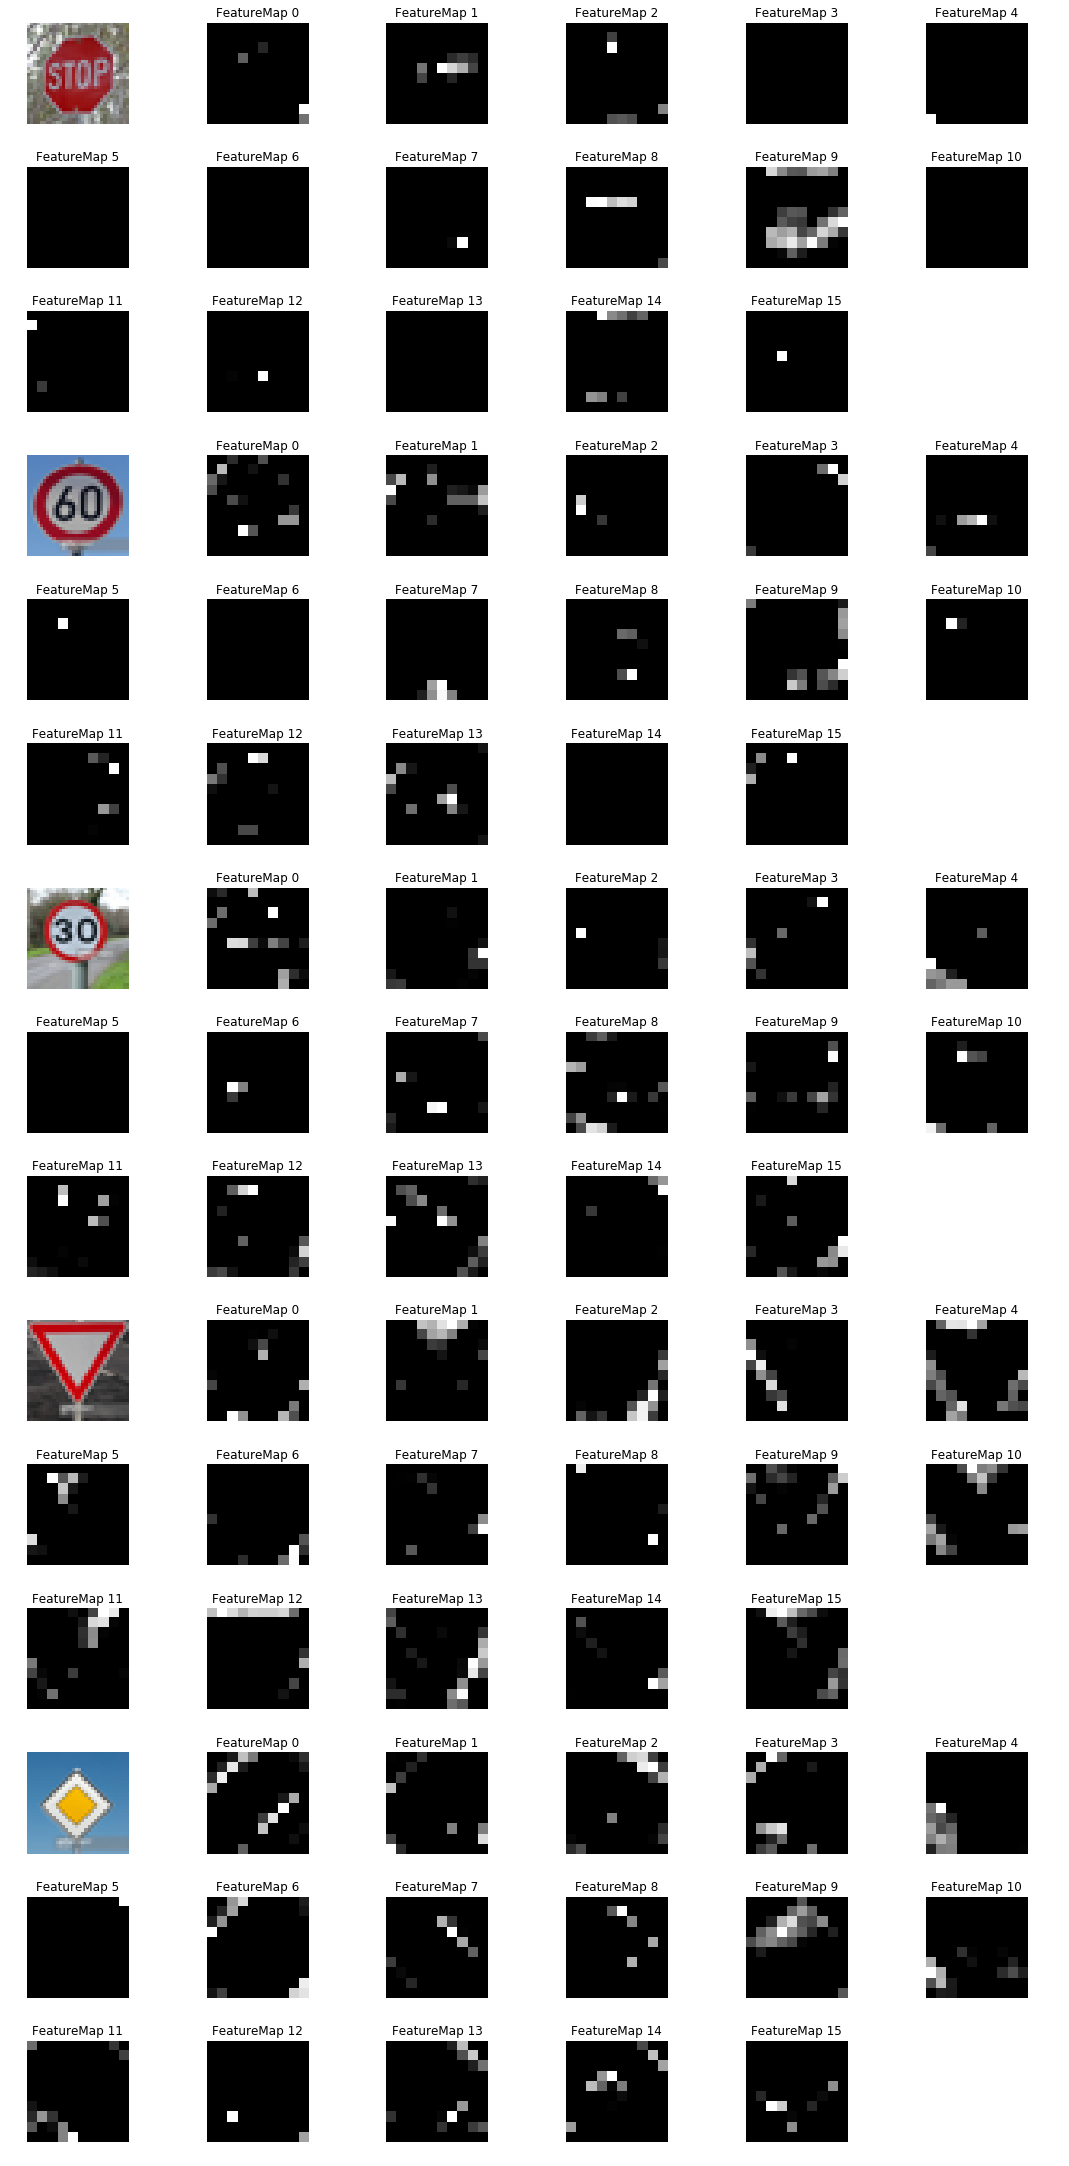

In [44]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    outputFeatureMap(for_test, preprocessed,conv2,name= 'images/convolution2.png',n_col=6,height=30)

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:** No idea. First layer looks like image, but second looks very strage

# please se the cell 41 - I think it generate absolutely the same output. Model is curtain on all write classified objects and completely lost on the object which have not been in training dataset

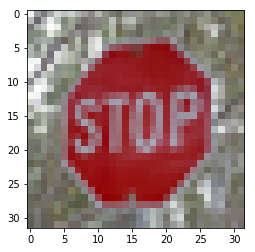

Image 0, real class Stop predicted class No entry


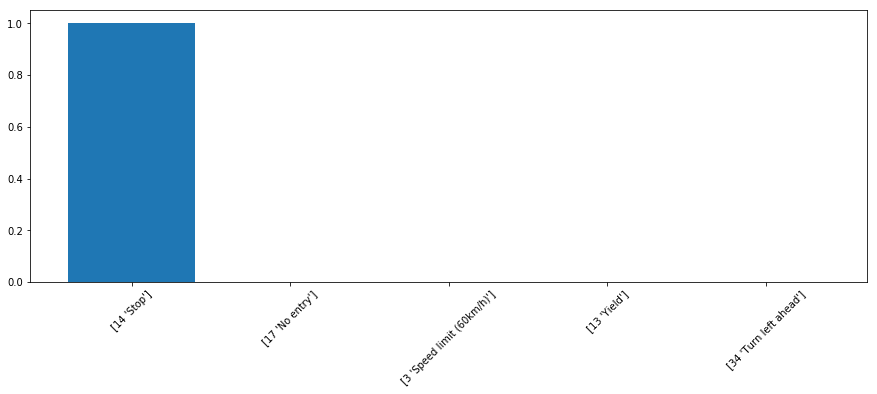

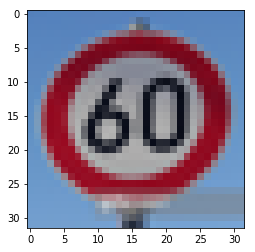

Image 1, real class Speed limit (60km/h) predicted class Speed limit (50km/h)


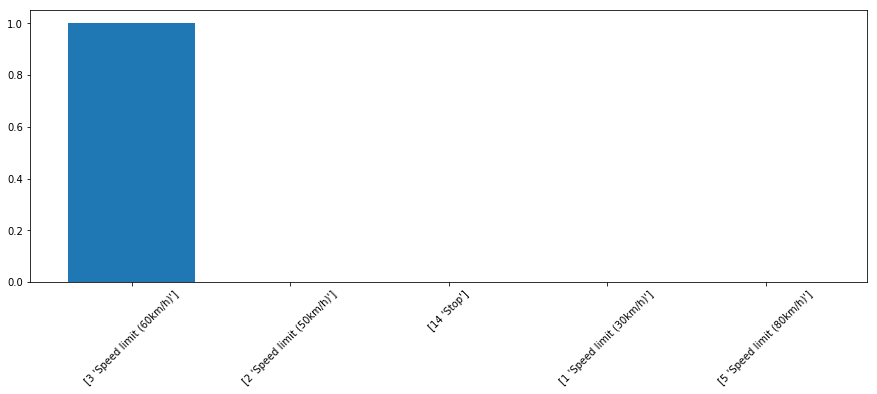

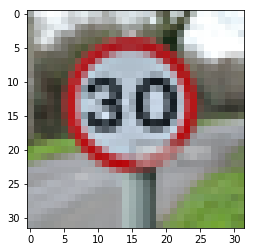

Image 2, real class Speed limit (30km/h) predicted class Slippery road


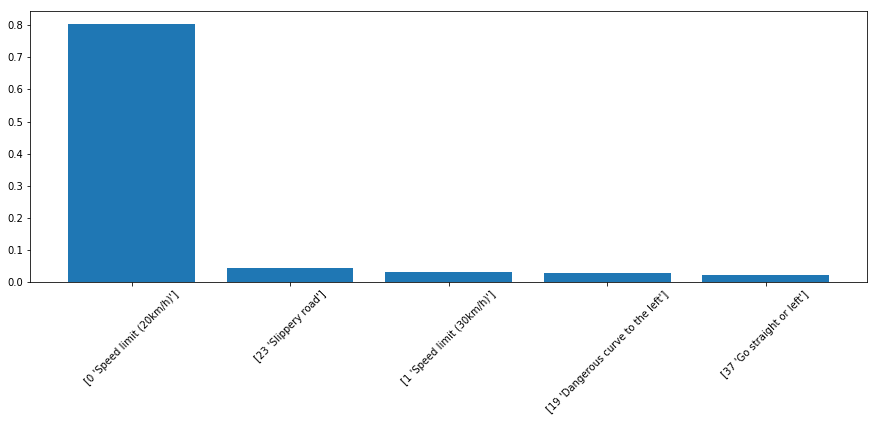

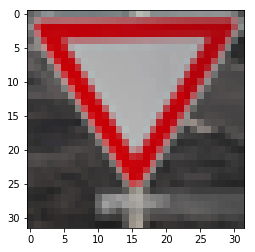

Image 3, real class Yield predicted class No vehicles


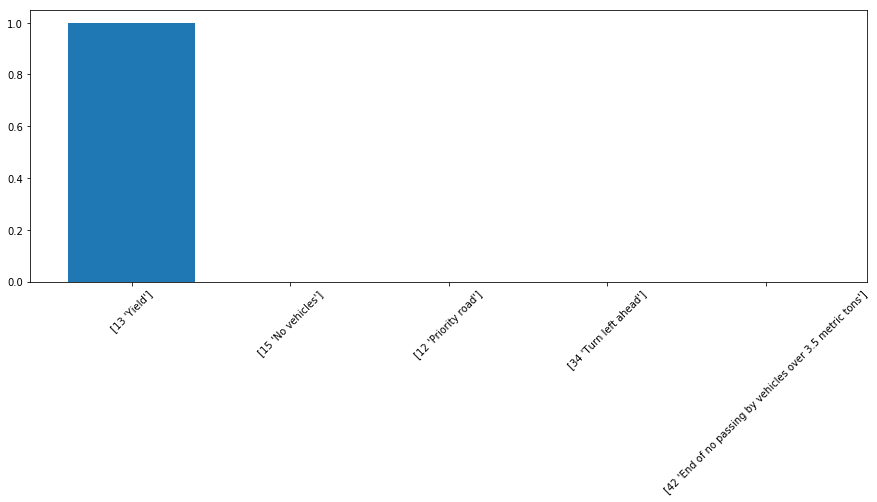

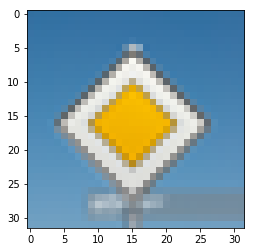

Image 4, real class Speed limit (50km/h) predicted class No passing for vehicles over 3.5 metric tons


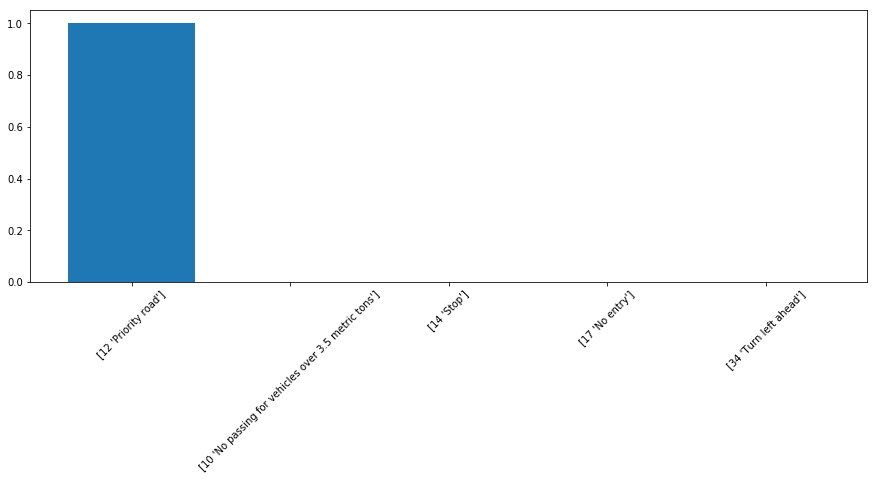

In [67]:
real_indicies=[14,3,1,13,2]

for i in range(5):
    plt.imshow(for_test[i])
    plt.show()
    print ('Image %d, real class %s predicted class %s' % (i,signames.values[real_indicies[i]][1],\
                                                            signames.values[top_k.indices[i][1]][1]))
    plt.figure(figsize=(15,5))
    plt.bar(range(5),top_k[0][i])
    plt.xticks(range(5),[signames.values[a] for a in top_k[1][i]],rotation=45)
    plt.show()

# let's look on miss classified sign

/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


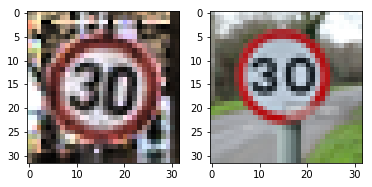

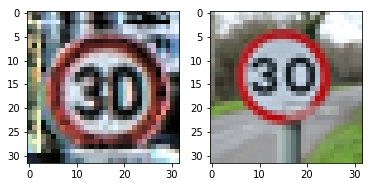

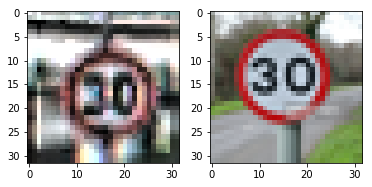

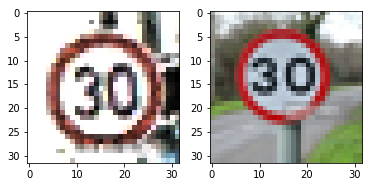

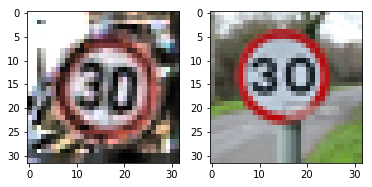

In [87]:
import random
w=np.where(y_test==1)[0]
random.shuffle(w)

for i in range(5):
    f, ax = plt.subplots(1,2)
    ax[0].imshow(preprocess_v3(X_test[w[i]]))
    ax[1].imshow(for_test[2])
    plt.show()

# ok, it's not a German one - it's from UK. 
## https://en.wikipedia.org/wiki/Road_speed_limits_in_the_United_Kingdom . Neural networks, like all other models use not the same "features" as people do to classify images. 

## the are a lot of papers that just small changes in image can completely change NN result (for example https://arxiv.org/pdf/1412.5068.pdf), but for this one we just do not have such type of objects in training dataset - so have to feel really lucky to think that our model will generalize the result on "similar" for us objects. Actually to make our model work on it we need to add Btirish signs in training set and we will have 

## About performance comparison: if we exclude this UK one, we have 100% on "new" dataset. On test we had 0.95. What do you mean about comparing the performance?